In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


2022-06-13 08:24:44.226149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 08:24:44.226208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

### Define the target model architecture

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

2022-06-13 08:24:47.473469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 08:24:47.473614: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 08:24:47.473678: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-06-13 08:24:47.474607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Now try the SafeKerasModel version

In [7]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [8]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test", num_samples=25, epochs=200)


- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.



In [9]:
#safeModel.__dict__


In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [11]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_optimizer_is_DP(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because optimizer does  contain key _was_dp_gradients_called so should be DP.


(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 58ms/step - loss: 2.4333 - accuracy: 0.5280 - val_loss: 2.4478 - val_accuracy: 0.4640
Epoch 2/20
10/10 [==============================] - 0s 40ms/step - loss: 1.9317 - accuracy: 0.5560 - val_loss: 2.2937 - val_accuracy: 0.4720
Epoch 3/20
10/10 [==============================] - 0s 48ms/step - loss: 1.5831 - accuracy: 0.5720 - val_loss: 2.2726 - val_accuracy: 0.4640
Epoch 4/20
10/10 [==============================] - 0s 43ms/step - lo

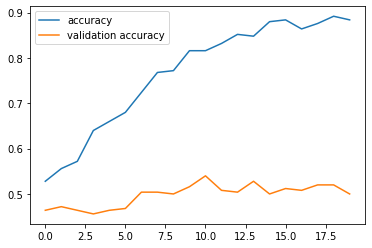

In [12]:
epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show() 


In [13]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_DP_used(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been run


## compute privacy

In [14]:
print(f'dataset has {Xt.shape[0]} entries so batch size is {100*safeModel.batch_size/Xt.shape[0]}%')
privacy = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=safeModel.batch_size,
                                              noise_multiplier=safeModel.noise_multiplier,
                                              epochs=25,#epochs,
                                              delta=1e-5)
print(f'with these settings privacy = {privacy}')

dataset has 500 entries so batch size is 5.0%
DP-SGD with sampling rate = 5% and noise_multiplier = 0.7 iterated over 500 steps satisfies differential privacy with eps = 18.4 and delta = 1e-05.
The optimal RDP order is 2.0.
with these settings privacy = (18.428440301602755, 2.0)


In [15]:
safeModel.save('safekeras.sav')

2022-06-13 08:25:42.391041: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: safekeras.sav/assets


In [16]:
safeModel.preliminary_check()

Model parameters are within recommended ranges.



('Model parameters are within recommended ranges.\n', False)

In [17]:
for key,value in safeModel.__dict__.items():
     print (f'thing associated with key {key} has type {type(value)}')

thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _obj_reference_counts_dict has type <class 'keras.utils.object_identity.ObjectIdentityDictionary'>
thing associated with key inputs has type <class 'list'>
thing associated with key outputs has type <class 'list'>
thing associated with key l2_norm_clip has type <class 'float'>
thing associated with key min_epsilon has type <class 'int'>
thing associated with key delta has type <class 'float'>
thing associated with key batch_size has type <class 'int'>
thing associated with key num_microbatches has type <class 'NoneType'>
thing associated with key learning_rate has type <class 'float'>
thing associated with key epochs has type <class 'int'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated 

In [18]:
all_keys = []
unusuals =[]
tuples =[]
deleted_keys = []

print("===============================================================================================")
print("Tuples")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == tuple):
        print (f'thing associated with key {key} has type {type(value)}')
        tuples.append(key)

print("===============================================================================================")
print("Bools")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == bool):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Lists")
print("===============================================================================================")        
for key,value in safeModel.__dict__.items():
    if(type(value) == list):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Strings")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == str):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Ints")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == int):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Floats")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == float):
        print (f'thing associated with key {key} has type {type(value)}')
        
print("===============================================================================================")
print("Dicts")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == dict):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Sets")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == set):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Unusual Ones")
print("===============================================================================================")

        
for key,value in safeModel.__dict__.items():
    if((type(value) != int) and (type(value) != str) and 
       (type(value) != list) and (type(value) != bool) and 
       (type(value) != tuple) and (type(value) != float) and
       (type(value) != dict) and (type(value) != set)):
        print (f'thing associated with key {key} has type {type(value)}')
        unusuals.append(key)

Tuples
thing associated with key _saved_model_arg_spec has type <class 'tuple'>
Bools
thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated with key _instrumented_keras_model_class has type <class 'bool'>
thing associated with key _trainable has type <class 'bool'>
thing associated with key _stateful has type <class 'bool'>
thing associated with key built has type <class 'bool'>
thing associated with key _supports_masking has type <class 'bool'>
thing associated with key _autocast has type <class 'bool'>
thing associated with key _expects_training_arg has type <class 'bool'>
thing associated with key _expects_mask_arg has type <class 'bool'>
thing associated with key _dynamic has type <class 'bool'>
thing associated wi

In [19]:
#safeModel.request_release('safekeras.pkl') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.sav') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.tf')




safeModel.save('my_model')
safeModel.save_weights('weights.h5')

safeModel.request_release('safe.sav')

INFO:tensorflow:Assets written to: my_model/assets
INFO:tensorflow:Assets written to: safe.sav/assets


_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://cc9aef99-f7f5-4410-8ef3-a8ce464cd5bd/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://2201df54-111f-4814-aba7-e61724e5e90a/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb964a74cd0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb964a74cd0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 2000 steps satisfies differential privacy with eps = 95 and delta = 1e-05.
The optimal RDP order is 1.5.


In [20]:


safeModel.request_release('safekeras.h5')

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://a589d4c6-1d14-41e1-af18-067fc449f892/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://d3b022e6-2425-496e-b838-a5dd55d0799b/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb964a74cd0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb964a74cd0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 2000 steps satisfies differential privacy with eps = 95 and delta = 1e-05.
The optimal RDP order is 1.5.


In [21]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 5s 66ms/step - loss: 0.5686 - accuracy: 0.8760 - val_loss: 3.3386 - val_accuracy: 0.4920
Epoch 2/20
10/10 [==============================] - 1s 56ms/step - loss: 0.5392 - accuracy: 0.8880 - val_loss: 3.4639 - val_accuracy: 0.4920
Epoch 3/20
10/10 [==============================] - 1s 79ms/step - loss: 0

# Testing
## Test 1 - researcher doesn't change recommended params

In [22]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel


# create and fit using recommended params


print("***Test 1: researcher doesn't change recommended params")
optimizer=None
safeKerasModel1 = Safe_KerasModel(inputs=input_data, outputs=output,name="safekerasmodel1-test", epochs=20)
safeKerasModel1.compile(loss=loss)
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save("safe1.h5", include_optimizer=False, save_format='h5')
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.h5")

***Test 1: researcher doesn't change recommended params
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 49ms/step - loss: 0.2558 - accuracy: 0.9360 - val_loss: 3.4435 - val_accuracy: 0.5800
Epoch 2/20
10/10 [==============================] - 0s 38ms/step - loss: 0.2741 - accuracy: 0.9520 - val_loss: 3.4912 - val_accuracy: 0.5760
Epoch 3/20
10/10 [

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://ebafbd05-96ed-49e6-af2d-bb4cb43742b9/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle

INFO:tensorflow:Assets written to: ram://fa786ec5-0052-4a09-b7fd-6527a4bfb5e5/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb96468a0a0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb96468a0a0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


## Test 2 - researcher changes params safely
Inputs: 

l2_norm_clip = 1.1, noise_multiplier=0.6

Expected Result:

Remain Unchanged l2_norm_clip = 1.1, noise_multiplier=0.6

In [23]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel2-test", l2_norm_clip = 1.1, noise_multiplier=0.6)
safeKerasModel2.optimizer=tensorflow_privacy.DPKerasAdamOptimizer
safeKerasModel2.compile(loss=loss)
safeKerasModel2.l2_norm_clip = 1.1
safeKerasModel2.noise_multiplier = 0.6
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)

safeKerasModel2.save("safe2.hd5")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.hd5")


***Test 2: researcher changes params safely
- parameter l2_norm_clip = 1.1 identified as greater than the recommended max value of 1.0.
Changed parameter l2_norm_clip = 1.0.
- parameter noise_multiplier = 0.6 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.6 iterated over 200 steps satisfies differential privacy with eps = 32.9 and delta = 1e-05.
The optimal RDP order is 1.75.
Current epsilon is 32.860767694468635
The requirements for DP are not met, current epsilon is: 32.860767694468635. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 46ms/step - loss: 168.5915 - accuracy: 0.5640 - val_loss: 553.4832 - val_accuracy: 0.5160
Epoch 2/20
10/10 [===============

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://c529a104-d1cf-418a-985e-becd35774892/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://f9e828df-5725-41bb-bcdf-f33ba03ae7c0/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94d6ba430>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94d6ba430>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.6 iterated over 200 steps satisfies differential privacy with eps = 32.9 and delta = 1e-05.
The optimal RDP order is 1.75.


## Test 3 - researcher changes string params unsafely
Expected result:

WARNING: model parameters may present a disclosure risk:
- parameter l2_norm_clip = 0.8 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.


In [24]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change one model params in an unsafe way
print("\n***Test 3: researcher changes params unsafely")
safeKerasModel3 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", l2_norm_clip = 0.8)
safeKerasModel3.compile(loss=loss)
#safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save("unsafe3.hd5")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.hd5")


***Test 3: researcher changes params unsafely
- parameter l2_norm_clip = 0.8 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 96ms/step - loss: 21192.9805 - accuracy: 0.6600 - val_loss: 33761.6953 - val_accuracy: 0.5520
Epoch 2/20
10/10 [===============

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://2eb94f65-9857-43b9-948f-afa994e01771/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://dd655a97-b4fa-4b77-a92b-1bfa40a712da/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb9641478e0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb9641478e0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


## Test 3 - researcher changes string params unsafely
Input delta = -1 

Expected Result:

WARNING: model parameters may present a disclosure risk:
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

In [25]:
# change another model params in an  unsafe way
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel4 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", delta=-1)
safeKerasModel4.compile(loss=loss)
#safeKerasModel3.optimizer="Adam"
safeKerasModel4.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel4.save("unsafe3.hd5")
safeKerasModel4.preliminary_check()
safeKerasModel4.request_release(filename="unsafe3.hd5")


***Test 3: researcher changes string params unsafely
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 2s 50ms/step - loss: 9722.3486 - accuracy: 0.7200 - val_loss: 27622.0703 - val_accuracy: 0.5240
Epoch 2/20
10/10 [====================

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://bb15841a-462a-460a-9e4f-ac171af4acd2/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://42072dbd-e243-4f25-9954-eb2ca630734f/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94d4dfb20>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94d4dfb20>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


## Test 5: researcher changes params unsafely
input: l2_norm_clip=0.9, noise_multipier=0.4, min_epsilon=9,delta=-1

Expected Result:

WARNING: model parameters may present a disclosure risk:
- parameter l2_norm_clip = 0.9 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.
- parameter min_epsilon = 9 identified as less than the recommended min value of 10.
Changed parameter min_epsilon = 10.
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

In [26]:
# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")

importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel


safeKerasModel4 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", l2_norm_clip=0.9, noise_multipier=0.4, min_epsilon=9,delta=-1)
safeKerasModel4.compile(loss=loss)
safeKerasModel4.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel4.save("unsafe4.hd5")
safeKerasModel4.preliminary_check()
safeKerasModel4.request_release(filename="unsafe4.hd5")


***Test 5: researcher changes string and numeric params unsafely
- parameter l2_norm_clip = 0.9 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [=============================

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://65a179b4-acb5-40c9-a0a5-b5c44c524d71/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://b739c37e-9085-44b9-9f30-50eec4b6cfbe/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94c397730>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94c397730>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


## Test 6 researcher changes params unsafely

Expected result:

Input optimizer = wobble

WARNING: model parameters may present a disclosure risk
Unknown optimizer wobble - Changed parameter optimizer = 'DPKerasSGDOptimizer'

In [27]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="wobble")
safeKerasModel6.compile(loss=loss)
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save("unsafe6.hd5")

safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.hd5")


***Test 6: researcher changes string and numeric params unsafely
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 50ms/step - loss: 4804.6997 - accuracy: 0.7800 - val_loss: 26603.5918 - val_accuracy: 0.5280
Epoch 2/20
10/10 [==============================] - 0s 47ms/step - loss: 4702.2446 - accur

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://0da1ad71-e154-4cbe-9aa7-4df6b39b1c1f/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://98f7fa30-f3c2-4712-b02c-985e2bffe951/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94ccf54c0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94ccf54c0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


## Test 7 researcher changes params unsafely

Inputs:

Input optimizer = Adam

Expected Result:

WARNING: model parameters may present a disclosure risk
Changed parameter optimizer = 'DPKerasAdamOptimizer'

In [28]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 7: researcher changes string and numeric params unsafely")
safeKerasModel7 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="Adam")
safeKerasModel7.compile(loss=loss)
safeKerasModel7.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel7.save("unsafe7.hd5")

safeKerasModel7.preliminary_check(apply_constraints=False)
safeKerasModel7.request_release(filename="unsafe7.hd5")


***Test 7: researcher changes string and numeric params unsafely
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 2s 48ms/step - loss: 22446.7578 - accuracy: 0.6320 - val_loss: 34621.1875 - val_accuracy: 0.5560
Epoch 2/20
10/10 [==============================] - 0s 41ms/step - loss: 22901.3047 - accuracy: 0.6440 - val_loss: 37963.7031 - val_accuracy:

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://a78844ad-f813-472c-9f63-adc8e3668b11/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://5917a623-e79b-49dc-b4f6-cc0236d0732e/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94ca070d0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94ca070d0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


### Dictionary Tests

In [29]:
import h5py
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 8: researcher changes string and numeric params unsafely")
safeKerasModel8 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="Adam")
safeKerasModel8.compile(loss=loss)
safeKerasModel8.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel8.save("unsafe8.h5", include_optimizer=False, save_format='h5')

#print("Now Load the file")

#importlib.reload(safemodel.safemodel)
#importlib.reload(safemodel.classifiers.safekeras)
#safeKerasModel8 = safeKerasModel8.load('unsafe8.h5')

#print('loaded file')




***Test 8: researcher changes string and numeric params unsafely
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
Current epsilon is 23.09099569905857
The requirements for DP are not met, current epsilon is: 23.09099569905857. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 4s 75ms/step - loss: 62992.5586 - accuracy: 0.6880 - val_loss: 137600.8125 - val_accuracy: 0.5280
Epoch 2/20
10/10 [==============================] - 0s 47ms/step - loss: 65764.5078 - accuracy: 0.6560 - val_loss: 135016.0469 - val_accurac

In [30]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel
f = tf.keras.models.load_model('unsafe8.h5', custom_objects={"Safe_KerasModel": Safe_KerasModel})
kerasmodelkeys =[]
for key,value in f.__dict__.items():
        #print ( f' key {key} : value {value} \n')
        kerasmodelkeys.append(key)

        
ourmodelkeys =[]
for key,value in safeKerasModel8.__dict__.items():
        #print ( f' key {key} : value {value} \n')
        ourmodelkeys.append(key)

print(f'Our model has {len(ourmodelkeys)} keys')
print(f'The keras model has {len(kerasmodelkeys)} keys')
ourmodelkeys.sort()
kerasmodelkeys.sort()

print(ourmodelkeys)

move_list = []

for key,value in f.__dict__.items():
        #print ( f' key {key} : value {value} \n')
        if(key in f.ignore_items):
            print ( f' key {key} is in ignore_list: value {value} \n')
            print ( f' key {key} is type {type(key)}\n')
            if(type(key) == type(move_list)):
              move_list.append(key)
            
        else:
            pass
print('Keys to move to examine_seperately')
print(move_list)


    


- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

Our model has 107 keys
The keras model has 105 keys
['_activity_regularizer', '_auto_track_sub_layers', '_autocast', '_base_model_initialized', '_build_input_shape', '_callable_losses', '_cluster_coordinator', '_compiled_trainable_state', '_compute_dtype_object', '_compute_output_and_mask_jointly', '_default_training_arg', '_distribution_strategy', '_dtype_policy', '_dynamic', '_enable_dict_to_input_mapping', '_expects_mask_arg', '_expects_training_arg', '_feed_input_names', '_feed_input_shapes', '_feed_inputs', '_inbound_nodes_value', '_initial_weights', '_input_coordinates', '_input_layers', '_input_spec', '_instrumented_keras_api', '_instrumented_keras_layer_class', '_instrumented_keras_model_class', '_is_compiled', '_is_graph_network', '_is_model_for_instrumentation', '_jit_compile', '_layer_call_argspecs', '_losses', '_metrics', '_metrics_lock', '

In [31]:
for key,value in safeKerasModel8.__dict__.items():
    if 'optimizer' in key:
        print ( f' key {key} : value {value} \n')

 key optimizer : value <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb9417c3e80> 



## dp_epsilon_met


In [32]:

import pandas as pd
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

samples = [250, 250, 250]
batch_sizes = [1, 5, 25]
epochs = [20, 200, 2500]
noisemult = [0.7, 0.8, 0.9]

okslist = []
epsilonslist = []
noisemultslist = []
sampleslist = []
batch_size_list = []
epochs_list = []

safeKerasModel8 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="Adam")

for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):
            sampleslist.append(samples[i])
            safeKerasModel8.noise_multiplier = noisemult[i]
            noisemultslist.append(noisemult[i])
            batch_size_list.append(batch_sizes[j])
            epochs_list.append(epochs[k])
            ok, epsilon = safeKerasModel8.dp_epsilon_met(num_examples=samples[i],batch_size=batch_sizes[j],epochs=epochs[k])
            okslist.append(ok)
            epsilonslist.append(epsilon)

for i in range(0, len(okslist)):
    pass
    #print(f'{okslist[i]} {epsilonslist[i]} {noisemultslist[i]} {sampleslist[i]} {epochs_list[i]}' )
    

    
mydf = pd.DataFrame(
    {'OK': okslist,
     'Epsilon': epsilonslist,
     'Noise Multiplier': noisemultslist,
     'Num Samples': sampleslist,
     'Epochs': epochs_list,
     'Batch Size': batch_size_list


    })

mydf.round(decimals=2).sort_values('Epsilon')


- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 50000 steps satisfies differential privacy with eps = 13.5 and delta = 1e-05.
The optimal RDP order is 2.5.
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 625000 steps satisfies differential privacy with eps = 69.7 and delta = 1e-05.
The optimal RDP order is 1.5.
DP-SGD with sampling rate = 2% and noise_multiplier = 0.7 iterated over 1000 steps satisfies differential privacy with eps = 10.4 and delta = 1e-05.
The optimal RDP order is 2.5.
DP-SGD with sampling rate = 2% and noise_multiplier = 0.7 iterated over 10000 steps satisfies differential privacy with eps = 35.8 and delt

,OK,Epsilon,Noise Multiplier,Num Samples,Epochs,Batch Size
18,True,2.18,0.9,250,20,1
9,True,2.93,0.8,250,20,1
0,True,4.38,0.7,250,20,1
21,True,5.45,0.9,250,20,5
19,True,7.13,0.9,250,200,1
12,True,7.21,0.8,250,20,5
10,True,9.33,0.8,250,200,1
3,False,10.42,0.7,250,20,5
1,False,13.51,0.7,250,200,1
24,False,13.51,0.9,250,20,25


### Meets DP Epsilon Criteria

In [33]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

epochs=20
batch_size=1
# change another model params in an  unsafe way i.e. Optimizer=Adam
print("\n***Test 9: Meets DP epsilon criteria")
safeKerasModel9 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel9-test", optimizer="Adam")
safeKerasModel9.compile(loss=loss)
safeKerasModel9.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel9.save("unsafe7.hd5")

safeKerasModel9.preliminary_check(apply_constraints=False)
safeKerasModel9.request_release(filename="unsafe9.hd5")


***Test 9: Meets DP epsilon criteria
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Epoch 1/20
250/250 [==============================] - 5s 11ms/step - loss: 456934.0625 - accuracy: 0.6320 - val_loss: 725983.1875 - val_accuracy: 0.5320
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 1014234.8750 - accuracy: 0.5080 - val_loss: 1701932.2500 - val_accuracy: 0.5200
Epoch 3/20
250/250 [==============================] - 4s 16ms/step - loss: 1694302.7500 - accuracy: 0.5480 - val_loss: 2437387.5000 - val_accuracy: 0.4800
Epoch 4/20
250/250 [==============================] - 4s 18ms/step - loss: 2739398.0000 - accuracy: 0.5040 - val_loss: 4270853.5000 - val_accuracy: 0.4680
Epoch 5/20
250/2

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://4ea71894-267a-4ea1-a024-79116be94a57/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://f4eb9fcf-fda6-4024-8611-94da9377c56e/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb96ad547c0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb96ad547c0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


### Test 10 Optimizer is set as DP Version from the start

In [34]:
import tensorflow_privacy as tf_privacy
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

epochs=20
batch_size=1
# change another model params in an  safe way i.e. Optimizer=tf_privacy.DPKerasAdamOptimizer
print("\n***Test 10: Optimizer is set as DP version from the start")
safeKerasModel10 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel10-test", optimizer=tf_privacy.DPKerasAdamOptimizer)
safeKerasModel10.compile(loss=loss)
safeKerasModel10.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel10.save("unsafe7.hd5")

safeKerasModel10.preliminary_check(apply_constraints=False)
safeKerasModel10.request_release(filename="unsafe10.hd5")


***Test 10: Optimizer is set as DP version from the start
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

(250, 300)
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Epoch 1/20
250/250 [==============================] - 7s 17ms/step - loss: 48419740.0000 - accuracy: 0.5040 - val_loss: 43625988.0000 - val_accuracy: 0.5560
Epoch 2/20
250/250 [==============================] - 3s 11ms/step - loss: 54712648.0000 - accuracy: 0.4920 - val_loss: 48792188.0000 - val_accuracy: 0.5160
Epoch 3/20
250/250 [==============================] - 3s 11ms/step - loss: 58343432.0000 - accuracy: 0.4720 - val_loss: 58727184.0000 - val_accuracy: 0.5040
Epoch 4/20
250/250 [==============================] - 3s 12ms/step - loss: 60288916.0000 - accuracy: 0.4560 - val_loss: 60446272.0000 - val_ac

_obj_reference_counts_dict cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_thread_local cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread._local' object
_metrics_lock cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://36a5ba64-6c10-4818-b6aa-8c3f03207ce9/assets


_trackable_saver cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
_self_unconditional_checkpoint_dependencies cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
_self_unconditional_dependency_names cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_loss cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
compiled_metrics cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://58fce0ee-520f-4222-8773-2423f07a22a1/assets


history cannot be copied
...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
train_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
test_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
train_tf_function cannot be copied
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94c1eb280>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fb94c1eb280>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.


### 

In [36]:
import pandas as pd
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

samples = [250, 250, 250]
batch_sizes = [1, 5, 25]
my_epochs = [20, 200, 2500]
noisemult = [0.7, 0.8, 0.9]

safeKerasModel11 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="Adam")

outpustring=''
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,3):

            safeKerasModel11.noise_multiplier = 0.7
            ok, epsilon, num_examples, batch_size, epochs = safeKerasModel11.check_epsilon(
                num_samples=samples[i], 
                batch_size=batch_sizes[i],
                epochs=my_epochs[i]
            )
            
            if(ok == True):
                outputstring = (f"DP Epsilon Met. epsilon {epsilon} with params: Num Samples: {num_examples} ; batch_size: {batch_size} ; Epochs: {epochs}")
            else:
                pass
if(len(outputstring)>1):
    print("---------------------------------------------------------------")
    print(outputstring)
                


- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.

DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Current epsilon is 4.382426906944152
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Current epsilon is 4.382426906944152
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Current epsilon is 4.382426906944152
DP-SGD with sampling rate = 0.4% and noise_multiplier = 0.7 iterated over 5000 steps satisfies differential privacy with eps = 4.38 and delta = 1e-05.
The optimal RDP order is 4.5.
Current epsilon is 4.38242690

DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 25000 steps satisfies differential privacy with eps = 733 and delta = 1e-05.
The optimal RDP order is 1.25.
The privacy estimate is likely to be improved by expanding the set of orders.
Current epsilon is 733.4442429856464
The requirements for DP are not met, current epsilon is: 733.4442429856464. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 2500
DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 25000 steps satisfies differential privacy with eps = 733 and delta = 1e-05.
The optimal RDP order is 1.25.
The privacy estimate is likely to be improved by expanding the set of orders.
Current epsilon is 733.4442429856464
The requirements for DP are not met, current epsilon is: 733.4442429856464. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 2500
------------------------------------